In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as units
import numpy as np
import os
from bokeh.plotting import *
output_notebook()
%load_ext autoreload
%autoreload 2
from getGaiaData import GaiaClusterMembers
from astropy.modeling.models import KingProjectedAnalytic1D
from astropy.modeling import models, fitting
import scipy.optimize
import scipy.stats as stats

Loading BokehJS ...

In [2]:
# read in my OC file and see if I can use that to define the input values
# https://github.com/ageller/compileOCs/blob/master/OCcompiled_clean.csv
#clusterName ='NGC_2682' #rtfac=3.5
#clusterName = 'NGC_188' #rtfac=3.5
#clusterName ='NGC_6819'#rtfac=2
clusterName ='M_35' #rtfac=1.5
#clusterName ='NGC_7789' #rtfac=1.5
#clusterName = 'NGC_2516' #rtfac=1.5
#clusterName = 'NGC_3532' #Either a very big cluster or the cluster is very small and ontop of field stars
#clusterName = 'NGC_2506' #rtfac=2
#clusterName = 'M_37' #rtfac=2
#clusterName = 'NGC_6811' #rtfac=2
#clusterName = 'NGC_6791' #rtfac=2
#clusterName = 'NGC_6866' #rtfac=2

OCdf = pd.read_csv('OCcompiled_clean_v2.csv')
row = OCdf.loc[OCdf['ID'] == clusterName].iloc[0]

# get the cluster center
center = SkyCoord(row['RA[hr]'], row['Dec[deg]'], unit=(units.hourangle, units.degree))
center.ra.to(units.degree).value
#calculate the distance modulus and error
dmod = 5.*np.log10(row['dist[pc]']) - 5.
err_dmod = (5.*1./np.log(10.)*(1./row['dist[pc]']))*row['err_dist[pc]'] # error propagation
# estimate the cluster tidal radius 
# equation from Binney and Tremaine for Jacoby Radius (8.91)
# want this in degrees
Mg = 1.5*10**12 #*units.solMass #this probably could use verification and a reference
rt = row['rgc[pc]']*(row['mass[Msun]']/(3.*Mg))**(1./3.)
rtfac = 2
radius = rtfac*np.arctan2(rt, row['dist[pc]'])*180./np.pi

In [3]:
radius

1.0008668260741458

Reading data from file M_35_dir/M_35_Gaia_data.ecsv ... 
Finding radial-velocity members ... 


Finding parallax members ... 
finding proper-motion members ...


/Users/annachilds/myBASE9/getGaiaData/getGaiaData.py:663: RuntimeWarning: invalid value encountered in divide
  RA_mems = gauss(x, *x_params[0][:3])/quad_norm(x, *x_params[0])
/Users/annachilds/myBASE9/getGaiaData/getGaiaData.py:664: RuntimeWarning: invalid value encountered in divide
  DEC_mems = gauss(y, *y_params[0][9:12])/quad_norm(y, *y_params[0])


combining memberships ...
fit parameters :
amplitude = 2.41 +/- 0.931
r_core = 35.8 +/- 10.9
r_tide = 1.68e+09 +/- 1e+16
plotting CMD ...
generating phot file ...
generating yaml file ...
done.


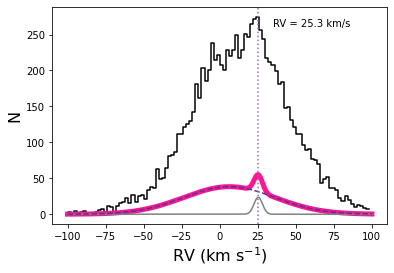

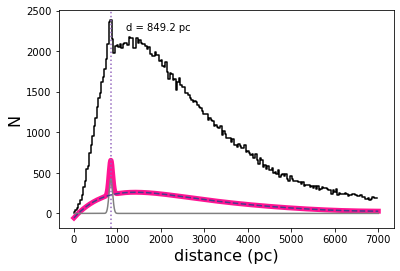

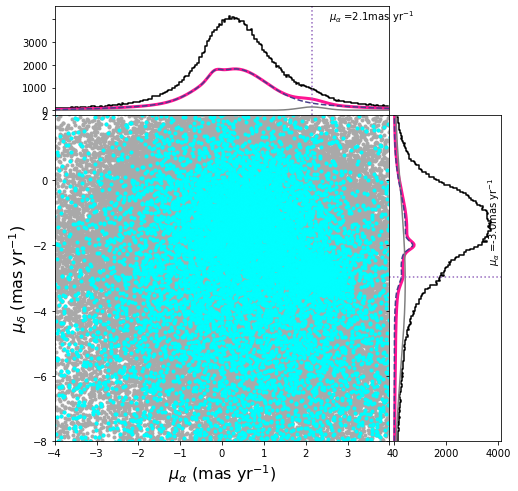

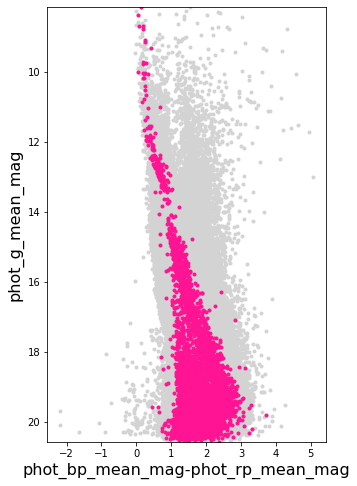

In [4]:
cluster = GaiaClusterMembers(center.ra.to(units.degree).value, center.dec.to(units.degree).value, radius)
pwd = clusterName+'_dir'
cluster.verbose = 1
try:
    os.makedirs(pwd+'/plots')
    os.makedirs(pwd)
except:
    next
cluster.photOutputFileName = pwd +'/'+clusterName + '.phot'
cluster.saveDataFile = pwd +'/'+clusterName + '.csv'
cluster.yamlOutputFileName = pwd + '/base9.yaml'
cluster.yamlTemplateFileName = 'template_base9.yaml'
cluster.yamlInputDict = {
    'photFile' : clusterName + '.phot',
    'outputFileBase' : pwd,
    'modelDirectory' : '/projects/p31721/BASE9/base-models/',
    'msRgbModel' : 5,
    'Fe_H' : [row['[Fe/H]'], row['[Fe/H]'], np.max([row['err_[Fe/H]'], 0.3])],
    'Av' : [row['Av[mag]'], row['Av[mag]'], np.max([row['err_Av[mag]'], 0.3])],
    'Y' : [0.29, 0.29, 0.0], # keep the defaults
    'carbonicity' : [0.38, 0.38, 0.0], # keep the defaults
    'logAge' : [np.log10(row['age[Myr]']*10**6), np.log10(row['age[Myr]']*10**6), np.inf],
    'distMod' : [dmod, dmod, np.max([err_dmod, 1.0])],
}
cluster.plotNameRoot = pwd+'/plots/'
cluster.photSigFloor = 0.03
cluster.runAll(clusterName,rt,pwd+'/'+clusterName+'_Gaia_data.ecsv')
#cluster.saveDataToFile(pwd+'/'+clusterName+'_Gaia_data_small.ecsv')

In [5]:
layout = cluster.createInteractiveIsochrone('PARSEC.model', 
                                            initialGuess = [
                                                cluster.yamlInputDict['logAge'][0], 
                                                cluster.yamlInputDict['Fe_H'][0],
                                                cluster.yamlInputDict['distMod'][0],
                                                cluster.yamlInputDict['Av'][0]
                                            ],
                                   mag = 'phot_g_mean_mag', color1 = 'phot_bp_mean_mag', color2 = 'phot_rp_mean_mag', xrng = [-1,4], yrng = [22,1])

# in order to run a Python callback in a Jupyter notbook, you need to include the following
def bkapp(doc):
    doc.add_root(layout)

show(bkapp)

generating phot file ...
initial and final yaml [starting, mean, sigma] values:
Fe_H: initial = [-0.16, -0.16, 0.3], final = [-0.16, -0.16, 0.3]
Av: initial = [0.8341333333333334, 0.8341333333333334, 0.3], final = [0.565, 0.8341333333333334, 0.3]
distMod: initial = [9.611921760641378, 9.611921760641378, 1.0], final = [9.88, 9.611921760641378, 1.0]
logAge: initial = [8.097785528117459, 8.097785528117459, inf], final = [8.097785528117459, 8.097785528117459, inf]
generating yaml file ...
Files saved :  M_35_dir/M_35.phot M_35_dir/base9.yaml


In [ ]:
#mask = (cluster.data['membership'] > cluster.membershipMin)
mask = np.logical_and(cluster.data['membership'] > cluster.membershipMin, cluster.data['phot_g_mean_mag'] < 16)

members = cluster.data[mask]
members['coord'] = SkyCoord(members['ra'], members['dec'], frame='icrs') 
members['rCenter'] = center.separation(members['coord']).to(units.arcmin)

# get the histogram of radial values
# set the radial bins (in arcmin)
bins = np.linspace(0, 60, 50)

# calculate the bin centers
bin_centers = bins[:-1] + np.diff(bins)[0]

# get the radial histogram (number in each bin)
nr,br = np.histogram(members['rCenter'],bins = bins)
#plt.hist(members['rCenter'],bins = bins)
# calculate the surface areas
sarea = np.array([bins[i+1]**2. - bins[i]**2. for i in range(len(bins) - 1)])

# calculate the surface density (N/area)
sdensity = nr/sarea

# calculate the uncertainty on the surface density (using propagation of errors and assuming zero uncertainty on the surface area)
err_sdensity = np.sqrt(nr)/sarea

# make sure that the errors are always non-zero (not sure the best approach here)
xx = np.where(err_sdensity == 0)
err_sdensity[xx] = 1./sarea[xx]
        # fit a King model
p_init = models.KingProjectedAnalytic1D(max(sdensity), np.median(bin_centers), rt)
fit_p = cluster.fitter
king = fit_p(p_init, bin_centers, sdensity, weights = 1.0/err_sdensity)

f,ax =plt.subplots()
ax.errorbar(bins[:-1], sdensity, yerr= err_sdensity, fmt = '.')

# get the parameters and the uncertainties
# https://github.com/astropy/astropy/issues/7202
param_names = king.param_names
params = king.parameters
#err_params = np.sqrt(np.diag(fit_p.fit_info['param_cov']))
print('fit parameters :')
for (x1,x2) in zip(param_names, params):
    print(f'{x1} = {x2:.3}')

In [ ]:
100/60